In [1]:
import pickle
import pandas as pd
import sklearn
import numpy as np
import scanpy as sc
import scipy.sparse
import anndata
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import copy
import logging as logg
from sklearn import preprocessing
import os 
import warnings
import scATAcat
import seaborn as sns
import random as rn 

warnings.filterwarnings('ignore')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


#### define necessary parameters

In [3]:

results_dir = "../../../../../results/Supplementary_tables/analysis_on_different_projections/FACS_BM_scATAC/application_with_Corces2016_prototypes/projection_with_prototype_PCs_prototype_features"
output_dir = results_dir +"/outputs/"
figures_dir = results_dir +"/figures/"
data_dir = "../../../../../../../scATAcat_notebooks_for_paper/jan2024/data/"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)


### 0 - Load scATAC-seq data

In [4]:
ENCODE_coverage_per_cell_df= pickle.load(open(data_dir + 'Buenrostro2018_FACS_BM_scATAC/scATACseq/02_ENCODE_coverage_by_cell_matrix/scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_complete_sparse.pkl','rb'))


In [5]:
pd.read_csv(data_dir +"Buenrostro2018_FACS_BM_scATAC/scATACseq/02_ENCODE_coverage_by_cell_matrix/scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_complete_features.csv", index_col=0)

,cCREs.1
cCREs,
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060
...,...
chrY_56842374_56842545,chrY_56842374_56842545
chrY_56844431_56844674,chrY_56844431_56844674
chrY_56857410_56857680,chrY_56857410_56857680


In [6]:
ENCODE_cCREs = pd.read_csv(data_dir +"Buenrostro2018_FACS_BM_scATAC/scATACseq/02_ENCODE_coverage_by_cell_matrix/scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_complete_features.csv", index_col=0)
ENCODE_cCREs.index.name = None
ENCODE_cCREs.columns = ['cCREs']
ENCODE_cCREs.head()

,cCREs
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060


In [7]:
cell_IDs = pd.read_csv(data_dir +"Buenrostro2018_FACS_BM_scATAC/scATACseq/02_ENCODE_coverage_by_cell_matrix/scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_complete_cell_IDs.csv", index_col=0)
cell_IDs.index.name = None
cell_IDs.columns = ['cell_IDs']
cell_IDs.head()

,cell_IDs
CLP_0,CLP_0
CLP_1,CLP_1
CMP_0,CMP_0
CMP_1,CMP_1
CMP_2,CMP_2


### 1 - initialize the AnnData object

In [8]:
sc_completeFeatures_adata = anndata.AnnData(ENCODE_coverage_per_cell_df.transpose().tocsr(), var=ENCODE_cCREs, obs=cell_IDs)


In [9]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'

### 2 - add binary layer to AnnData

In [10]:
scATAcat.add_binary_layer(sc_completeFeatures_adata, binary_layer_key="binary")

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    layers: 'binary'

## 3- calculate & plot cell and feature statistics

In [11]:
scATAcat.cell_feature_statistics(sc_completeFeatures_adata, binary_layer_key ='binary')

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

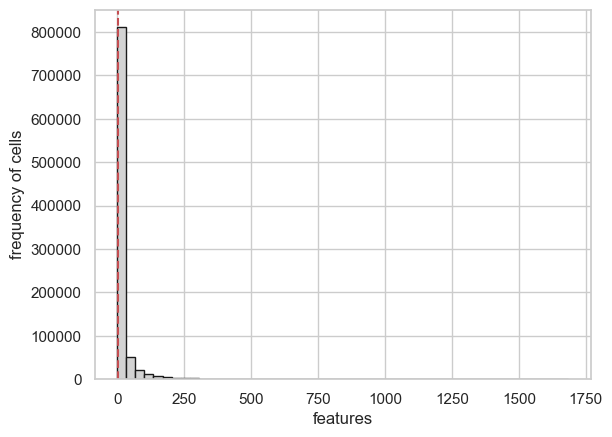

In [12]:
scATAcat.plot_feature_statistics(sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

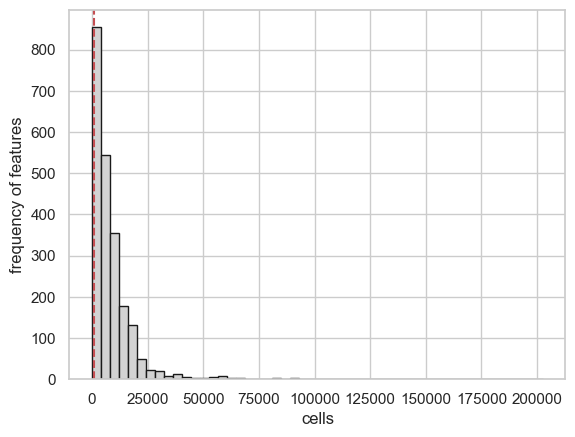

In [13]:
scATAcat.plot_cell_statistics(sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

## 4- filter the cells and features

In [14]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

In [15]:
sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(sc_completeFeatures_adata,cell_cutoff=1000,cell_cutoff_max=80000, feature_cutoff=3, remove_chrY = True, var_key = 'cCREs', copy=True)

In [16]:
sc_filteredFeatures_adata

View of AnnData object with n_obs × n_vars = 1872 × 501699
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

#### note that here we filtered almost half of the features!

### 5- load & preprocess the bulk data

In [17]:
bulk_by_ENCODE_peaks_df_annotated =  pickle.load(open(data_dir + "Corces2016_bulk_ATAC/02_ENCODE_coverage_by_prototypes_matrix/Corces2016bulkATAC_ENCODE_cCRE_overlappingPeaks_annotated.pkl", 'rb'))
bulk_by_ENCODE_peaks_df_annotated = bulk_by_ENCODE_peaks_df_annotated.reindex(sorted(bulk_by_ENCODE_peaks_df_annotated.columns), axis=1)

In [18]:
bulk_by_ENCODE_peaks_df_annotated.columns

Index(['Bcell_1', 'Bcell_2', 'Bcell_3', 'Bcell_4', 'CD34_Bone_Marrow_1',
       'CD34_Bone_Marrow_2', 'CD34_Cord_Blood_1', 'CD4Tcell_1', 'CD4Tcell_2',
       'CD4Tcell_3', 'CD4Tcell_4', 'CD4Tcell_5', 'CD8Tcell_1', 'CD8Tcell_2',
       'CD8Tcell_3', 'CD8Tcell_4', 'CD8Tcell_5', 'CLP_1', 'CLP_2', 'CLP_3',
       'CLP_4', 'CLP_5', 'CMP_1', 'CMP_2', 'CMP_3', 'CMP_4', 'CMP_5', 'CMP_6',
       'CMP_7', 'CMP_8', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6',
       'Ery_7', 'Ery_8', 'GMP_1', 'GMP_2', 'GMP_3', 'GMP_4', 'GMP_5', 'GMP_6',
       'GMP_7', 'HSC_1', 'HSC_2', 'HSC_3', 'HSC_4', 'HSC_5', 'HSC_6', 'HSC_7',
       'LMPP_1', 'LMPP_2', 'LMPP_3', 'MEP_1', 'MEP_2', 'MEP_3', 'MEP_4',
       'MEP_5', 'MEP_6', 'MEP_7', 'MPP_1', 'MPP_2', 'MPP_3', 'MPP_4', 'MPP_5',
       'MPP_6', 'Mono_1', 'Mono_2', 'Mono_3', 'Mono_4', 'Mono_5', 'Mono_6',
       'NKcell_1', 'NKcell_2', 'NKcell_3', 'NKcell_4', 'NKcell_5', 'NKcell_6'],
      dtype='object')

In [19]:
# subset to progenitors:
bulk_by_ENCODE_peaks_df_annotated = bulk_by_ENCODE_peaks_df_annotated[['CLP_1', 'CLP_2', 'CLP_3',
       'CLP_4', 'CLP_5', 'CMP_1', 'CMP_2', 'CMP_3', 'CMP_4', 'CMP_5', 'CMP_6',
       'CMP_7', 'CMP_8', 'GMP_1', 'GMP_2', 'GMP_3', 'GMP_4', 'GMP_5', 'GMP_6',
       'GMP_7', 'HSC_1', 'HSC_2', 'HSC_3', 'HSC_4', 'HSC_5', 'HSC_6', 'HSC_7',
       'LMPP_1', 'LMPP_2', 'LMPP_3', 'MEP_1', 'MEP_2', 'MEP_3', 'MEP_4',
       'MEP_5', 'MEP_6', 'MEP_7', 'MPP_1', 'MPP_2', 'MPP_3', 'MPP_4', 'MPP_5',
       'MPP_6']]

In [20]:
bulk_by_ENCODE_peaks_df_annotated

,CLP_1,CLP_2,CLP_3,CLP_4,CLP_5,CMP_1,CMP_2,CMP_3,CMP_4,CMP_5,...,MEP_4,MEP_5,MEP_6,MEP_7,MPP_1,MPP_2,MPP_3,MPP_4,MPP_5,MPP_6
chr1_181251_181601,0,5,0,0,0,0,1,9,7,3,...,3,4,7,10,0,4,1,2,5,10
chr1_190865_191071,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
chr1_778562_778912,72,94,78,64,23,96,83,192,115,84,...,58,84,291,252,96,193,131,52,268,420
chr1_779086_779355,11,10,10,9,0,12,15,16,19,8,...,8,11,34,33,13,20,9,7,43,72
chr1_779727_780060,4,4,2,0,0,0,1,3,0,0,...,2,5,7,4,0,1,2,0,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY_56842374_56842545,5,12,4,1,0,0,1,0,1,4,...,3,1,10,3,1,1,8,3,2,6
chrY_56844431_56844674,10,13,2,0,0,0,0,0,1,5,...,2,3,3,1,1,1,7,5,2,0
chrY_56857410_56857680,4,9,0,0,0,0,0,3,1,0,...,2,5,2,4,1,0,2,5,0,1
chrY_56857917_56858119,6,9,5,0,0,0,0,0,1,0,...,6,1,0,4,4,0,2,6,4,0


In [21]:
bulk_completeFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(bulk_by_ENCODE_peaks_df_annotated)

In [22]:
bulk_completeFeatures_adata

AnnData object with n_obs × n_vars = 43 × 926535
    obs: 'cell_types'
    var: 'cCREs'

In [23]:
bulk_completeFeatures_adata = scATAcat.preprocess_bulk_adata(bulk_completeFeatures_adata, remove_chrY=True, var_key = 'cCREs', copy=False)

### 6 - Overlap bulk and sc features

- before we proceed with sc analysis, we need to overlap the features:
    - we don't want the feature that does not have any counts in bulk data to influence clustering
    - similarly, we want the projection to be defined only with the same feature set

In [24]:
sc_bulk_common_vars = scATAcat.overlap_vars(sc_filteredFeatures_adata, bulk_completeFeatures_adata)

In [25]:
len(sc_bulk_common_vars)

501699

In [26]:
sc_commonFeatures_adata = scATAcat.subset_adata_vars(sc_filteredFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


In [27]:
bulk_commonFeatures_adata = scATAcat.subset_adata_vars(bulk_completeFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


### 7- doublet removal. As the data is genetated with sorted single cells, we did not perform doublet removal

### 8- apply TF-IDF

In [28]:
scATAcat.apply_TFIDF_sparse(sc_commonFeatures_adata, binary_layer_key='binary', TFIDF_key='TF_logIDF' )

AnnData object with n_obs × n_vars = 1872 × 501699
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

### 9 - subset matrices to differential cCREs

In [30]:
pairwise_top2000_cCREs = pd.read_table("../../../../../../data/Corces2016_bulk_ATAC/03_get_differentially_accessible_regions/only_progenitors-for_FACS_BM_scATAC/Corces2016_pairwise_differential_cCREs_FDR0.05_top2000_sorted_exactCREs.csv",delimiter="\t",header=None)
pairwise_top2000_cCREs.head()

,0
0,chr1_1842820_1843169
1,chr1_1895700_1895891
2,chr1_1895944_1896292
3,chr1_1966481_1966686
4,chr1_2045674_2045954


In [31]:
len(pairwise_top2000_cCREs)

21034

In [32]:
common_differential_vars = list(set(list(sc_bulk_common_vars)) & set(list(pairwise_top2000_cCREs[0].tolist())))

len(common_differential_vars)

19412

In [33]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [34]:
sc_commonDiffFeatures_adata = scATAcat.subset_adata_vars(sc_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

### 10- dimention reduction and clustering 

In [35]:
sc_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 1872 × 19412
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

In [36]:
scATAcat.apply_PCA(sc_commonDiffFeatures_adata, layer_key ='TF_logIDF', svd_solver='arpack', random_state=0)


AnnData object with n_obs × n_vars = 1872 × 19412
    obs: 'cell_IDs'
    var: 'cCREs'
    uns: 'pca'
    obsm: 'num_feature_per_cell', 'X_pca'
    varm: 'num_cell_per_feature', 'PCs'
    layers: 'binary', 'TF_logIDF'

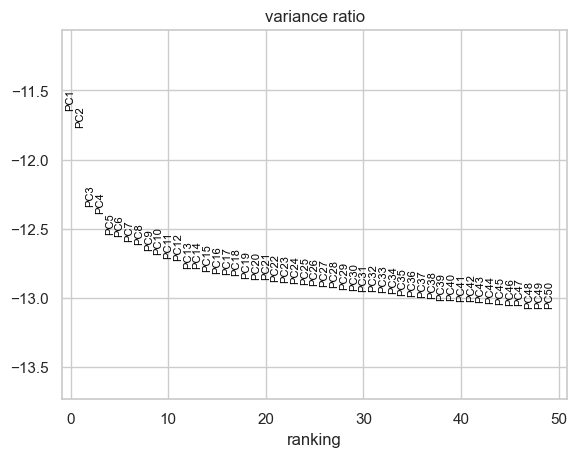

In [37]:
with plt.rc_context():
    sc.pl.pca_variance_ratio(sc_commonDiffFeatures_adata, n_pcs=50, log=True, show=False)
    plt.savefig(figures_dir + "/pca_variance_ratio.pdf", bbox_inches="tight")

In [38]:
sc.pp.neighbors(sc_commonDiffFeatures_adata, n_pcs = 50, n_neighbors = 30, random_state=0)


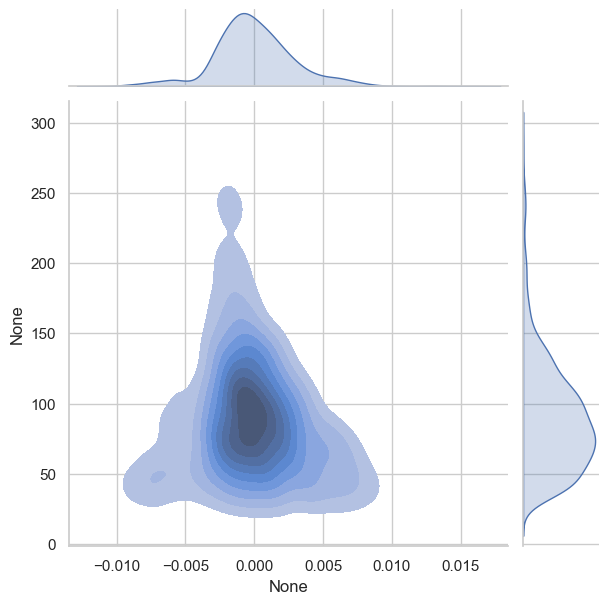

In [39]:
seqDepth_PC1_plot = sns.jointplot(
    x=sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    y=np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']),
    kind="kde",fill=True
)

Text(0, 0.5, 'num_feature_per_cell')

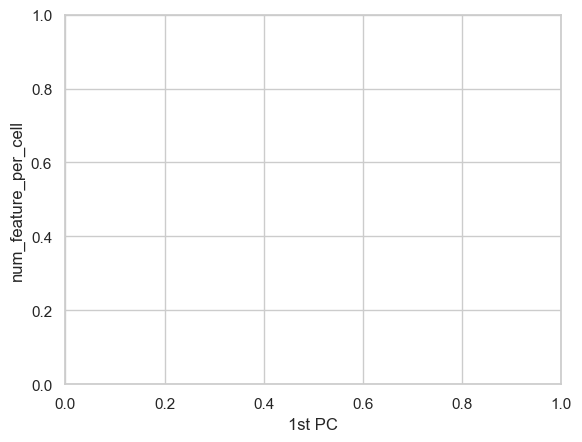

In [40]:
## correlation
np.corrcoef(sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']))
plt.xlabel("1st PC")
plt.ylabel("num_feature_per_cell")

### 11 -  apply UMAP & leiden clustering

In [41]:
leiden_resolution=1.0
leiden_key="leiden_"+ str(leiden_resolution)

In [42]:
sc.tl.umap(sc_commonDiffFeatures_adata, random_state=0)

In [43]:
sc.tl.leiden(sc_commonDiffFeatures_adata, resolution=leiden_resolution,key_added=leiden_key, random_state=0)

In [44]:
# specifiy the colors implicity for paper
sc_commonDiffFeatures_adata.uns[leiden_key +'_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

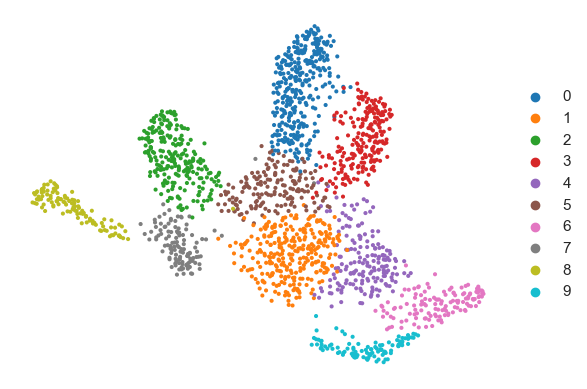

In [45]:
with plt.rc_context():
    sc.pl.umap(sc_commonDiffFeatures_adata, color=leiden_key, show=False,size=35 , add_outline=False, frameon=False, title="")
    plt.savefig(figures_dir + "/"+ leiden_key+ ".pdf", bbox_inches="tight")

In [46]:
# add cell types as obs
sc_commonDiffFeatures_adata.obs["cell_type"] = [r.split('_')[0] for r in sc_commonDiffFeatures_adata.obs.cell_IDs]
sc_commonDiffFeatures_adata.obs

,cell_IDs,leiden_1.0,cell_type
CLP_1,CLP_1,8,CLP
CMP_0,CMP_0,4,CMP
CMP_1,CMP_1,4,CMP
CMP_2,CMP_2,1,CMP
CMP_3,CMP_3,6,CMP
...,...,...,...
LMPP_90,LMPP_90,7,LMPP
LMPP_91,LMPP_91,7,LMPP
LMPP_93,LMPP_93,7,LMPP
LMPP_94,LMPP_94,7,LMPP


In [47]:
# manually set new colors # E4E858
sc_commonDiffFeatures_adata.uns['cell_type_colors'] =['#82018F',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"]

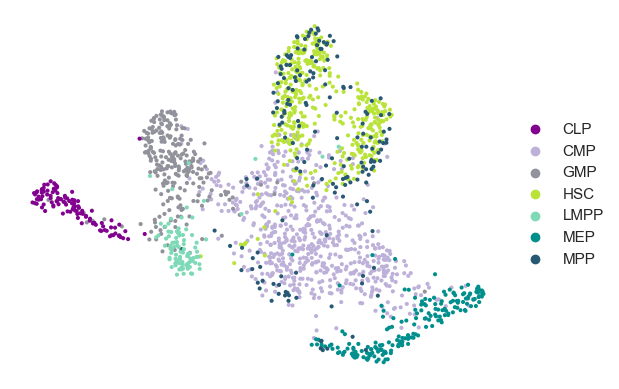

In [48]:
with plt.rc_context(): 
    sc.pl.umap(sc_commonDiffFeatures_adata, color='cell_type', add_outline=False, frameon=False,title ="", show=False, size=35 )
    plt.savefig(figures_dir + "/cell_types_umap_matching_colors.pdf", bbox_inches="tight")

#### loook at sequencing depth

In [49]:
sc_commonDiffFeatures_adata.obs['num_feature_per_cell_'] = sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']

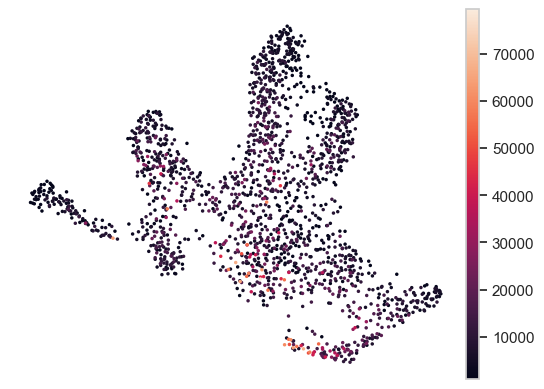

<Figure size 640x480 with 0 Axes>

In [50]:

with plt.rc_context():  
    sc.pl.umap(sc_commonDiffFeatures_adata, color='num_feature_per_cell_', add_outline=False, frameon=False,title ="", save=False, size=25 )
    plt.savefig(figures_dir + "/seq_depth_umap.pdf", bbox_inches="tight")

### 12 - from pseudobulks according to the cluster assignments


In [51]:
cell_cluster_assignments = pd.DataFrame(sc_commonDiffFeatures_adata.obs[leiden_key].copy())
cell_cluster_assignments


,leiden_1.0
CLP_1,8
CMP_0,4
CMP_1,4
CMP_2,1
CMP_3,6
...,...
LMPP_90,7
LMPP_91,7
LMPP_93,7
LMPP_94,7


In [52]:
cell_cluster_sizes = pd.DataFrame(cell_cluster_assignments[leiden_key].value_counts())
cell_cluster_sizes['leiden_clusters'] = cell_cluster_sizes.index
cell_cluster_sizes.head()

,count,leiden_clusters
leiden_1.0,,
0,344,0
1,286,1
2,233,2
3,212,3
4,174,4


In [53]:
for clust_id in set(sc_commonDiffFeatures_adata.obs[leiden_key].values):
    clust_df= sc_commonDiffFeatures_adata[sc_commonDiffFeatures_adata.obs[leiden_key]==clust_id]

In [54]:
cell_types = ([(r.split('_')[0]) for r in clust_df.obs[leiden_key].index])

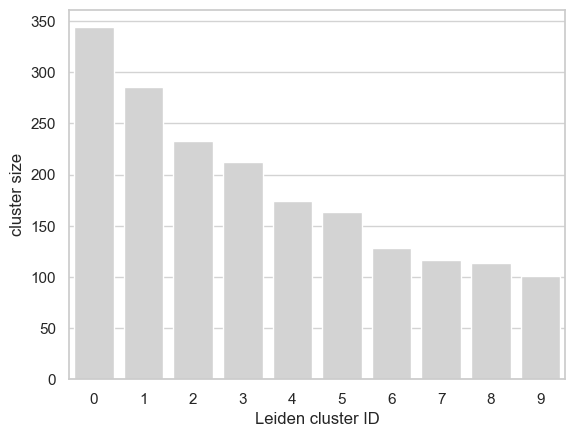

In [55]:
# plot a bar chart
sns.set_style("whitegrid")
ax= sns.barplot(
    y="count", 
    x="leiden_clusters", 
    data=cell_cluster_sizes, 
    color='lightgrey');
ax.yaxis.grid(True,color="lightgrey")
ax.axes.set_xlabel("Leiden cluster ID")
ax.axes.set_ylabel("cluster size")
#atickt(yticks=(list(range(0,1500,100))))
plt.savefig(figures_dir + "/cluster_sizes_"+leiden_key+".pdf", dpi=250)

In [56]:
pseudobulk_commonFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(scATAcat.get_pseudobulk_matrix_ext(adata_to_subset=sc_commonFeatures_adata, adata_to_get_clusters=sc_commonDiffFeatures_adata, cluster_key=leiden_key  ,method = 'sum'))

In [57]:
scATAcat.preprocessing_libsize_norm_log2(pseudobulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 10 × 501699
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [58]:
scATAcat.preprocessing_libsize_norm_log2(bulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 43 × 501699
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

### 13 - Projection


#### processing 

In [59]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [60]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [61]:
pseudobulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(pseudobulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [62]:
scATAcat.preprocessing_standardization(bulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=True)

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [63]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [64]:
scATAcat.preprocessing_standardization(pseudobulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=False,
                              output_layer_key= "libsize_norm_log2_bulk_scaled_diff",
                              std_key= None,  mean_key=None,
                              std_ = bulk_commonDiffFeatures_adata.var["feature_std"],
                              mean_= bulk_commonDiffFeatures_adata.var["feature_mean"])

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 10 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_bulk_scaled_diff'

In [65]:
## as an option, I can add the color codes from the clustering/ sc adata as a paramater for the pseudobulk matrix 
leiden_color_key = leiden_key+"_colors"
pseudobulk_commonDiffFeatures_adata.uns[leiden_color_key] = sc_commonDiffFeatures_adata.uns[leiden_color_key]

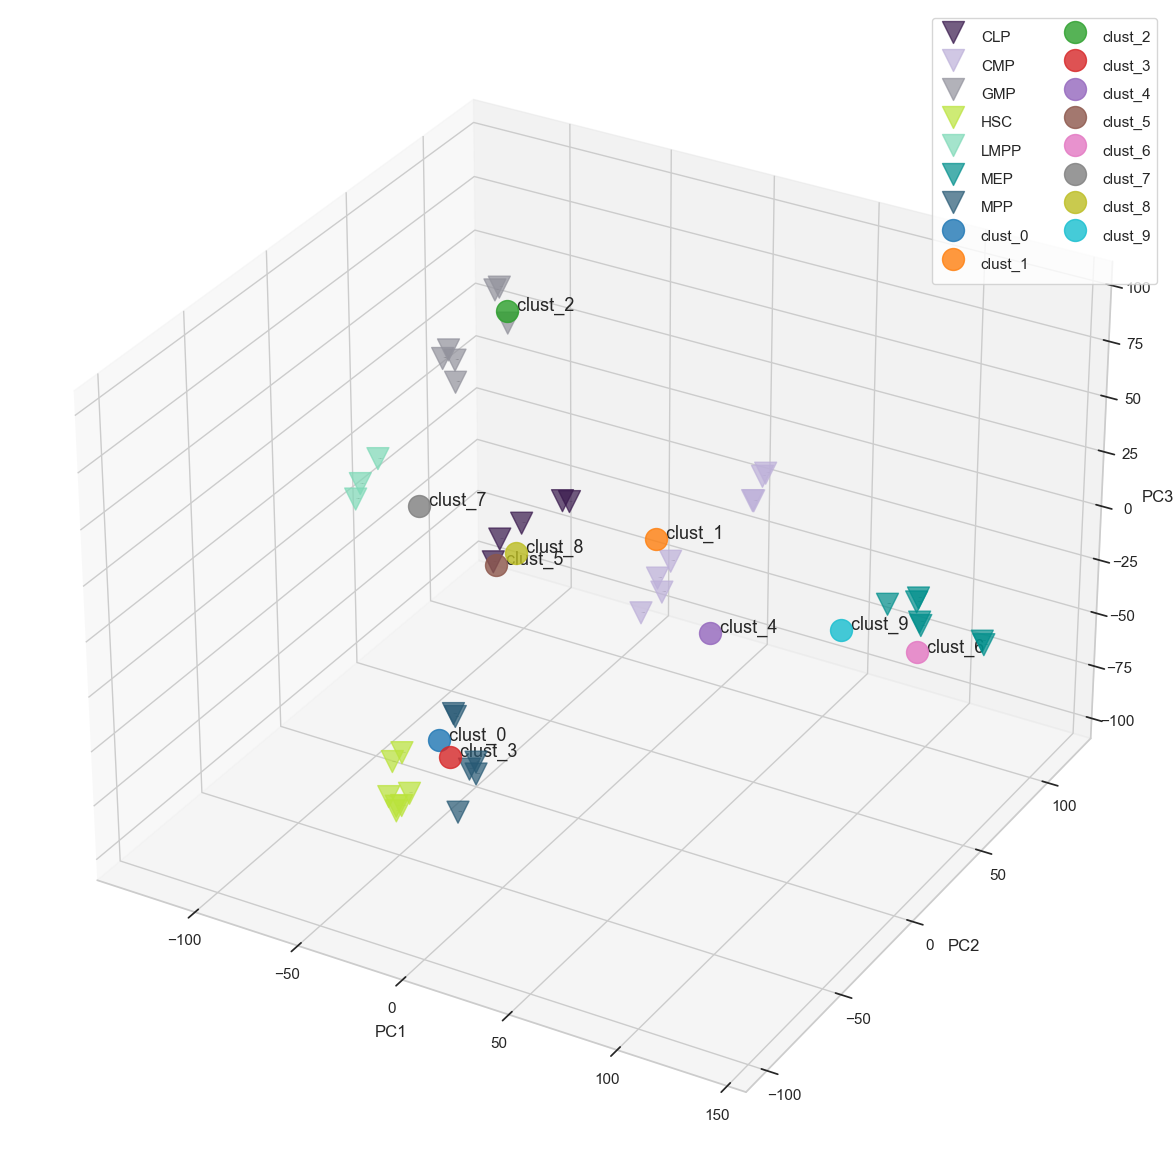

In [66]:
result= scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =13, prototype_label_font_size = 0,
prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection.png")

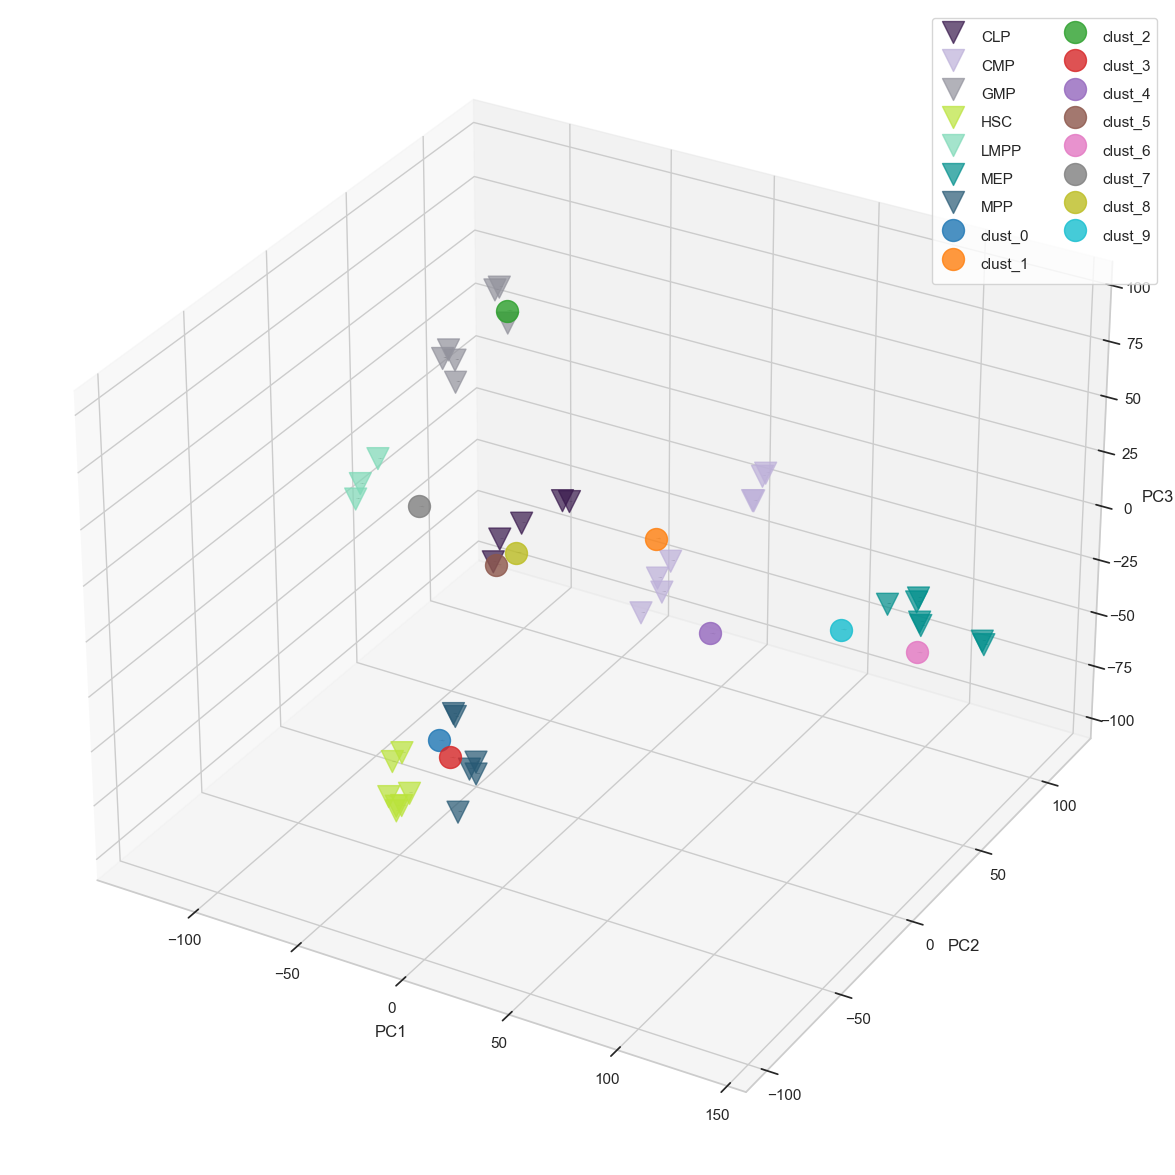

In [67]:
result_noLabel = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection_noLabel.png")

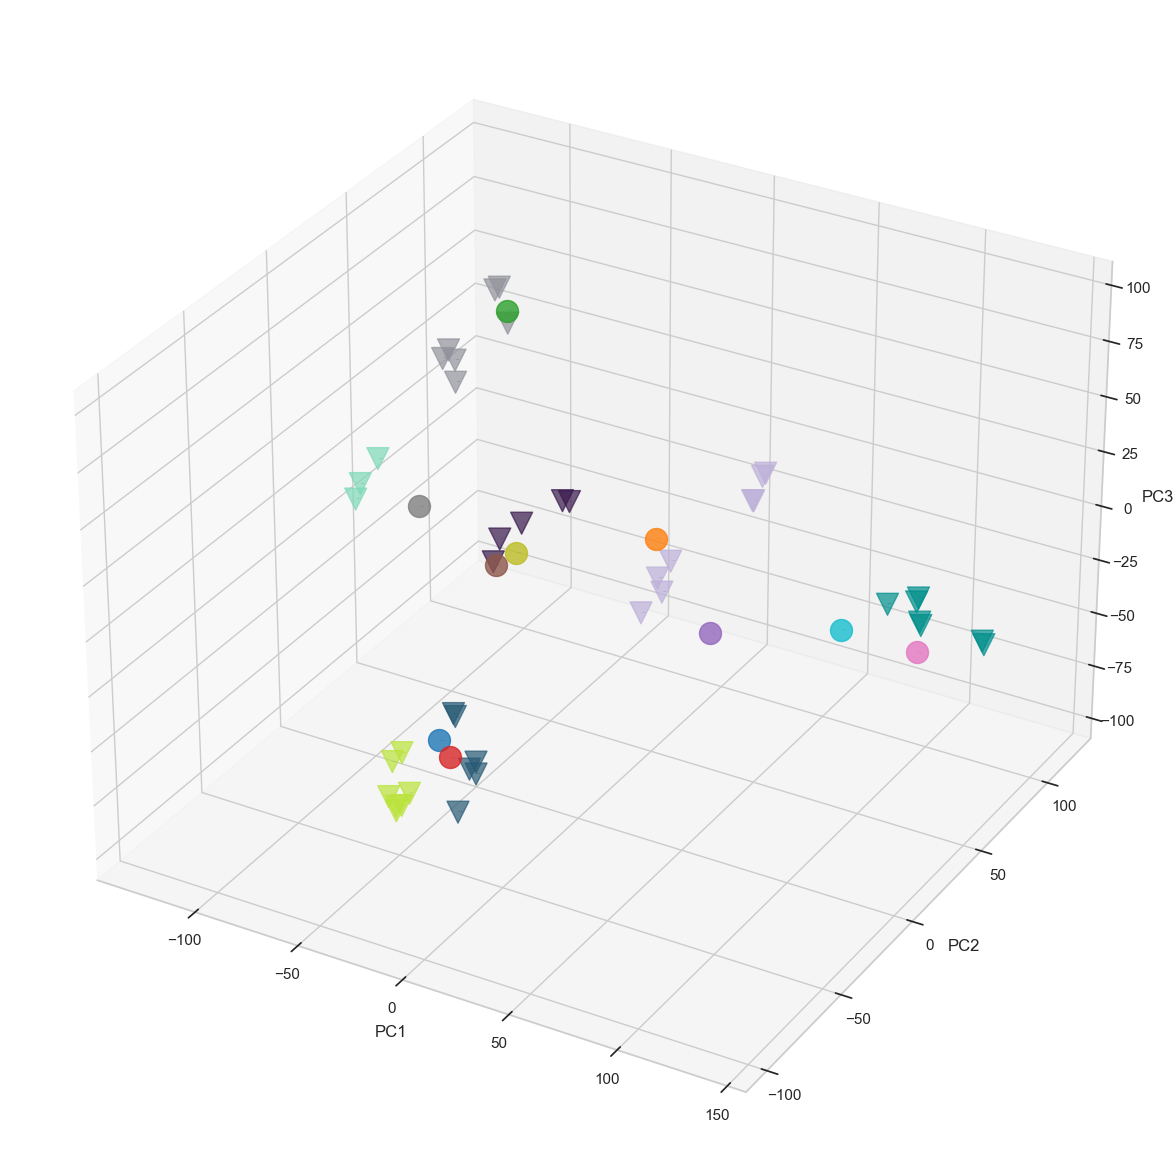

In [68]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.png", fig_size_inches=(15,15))


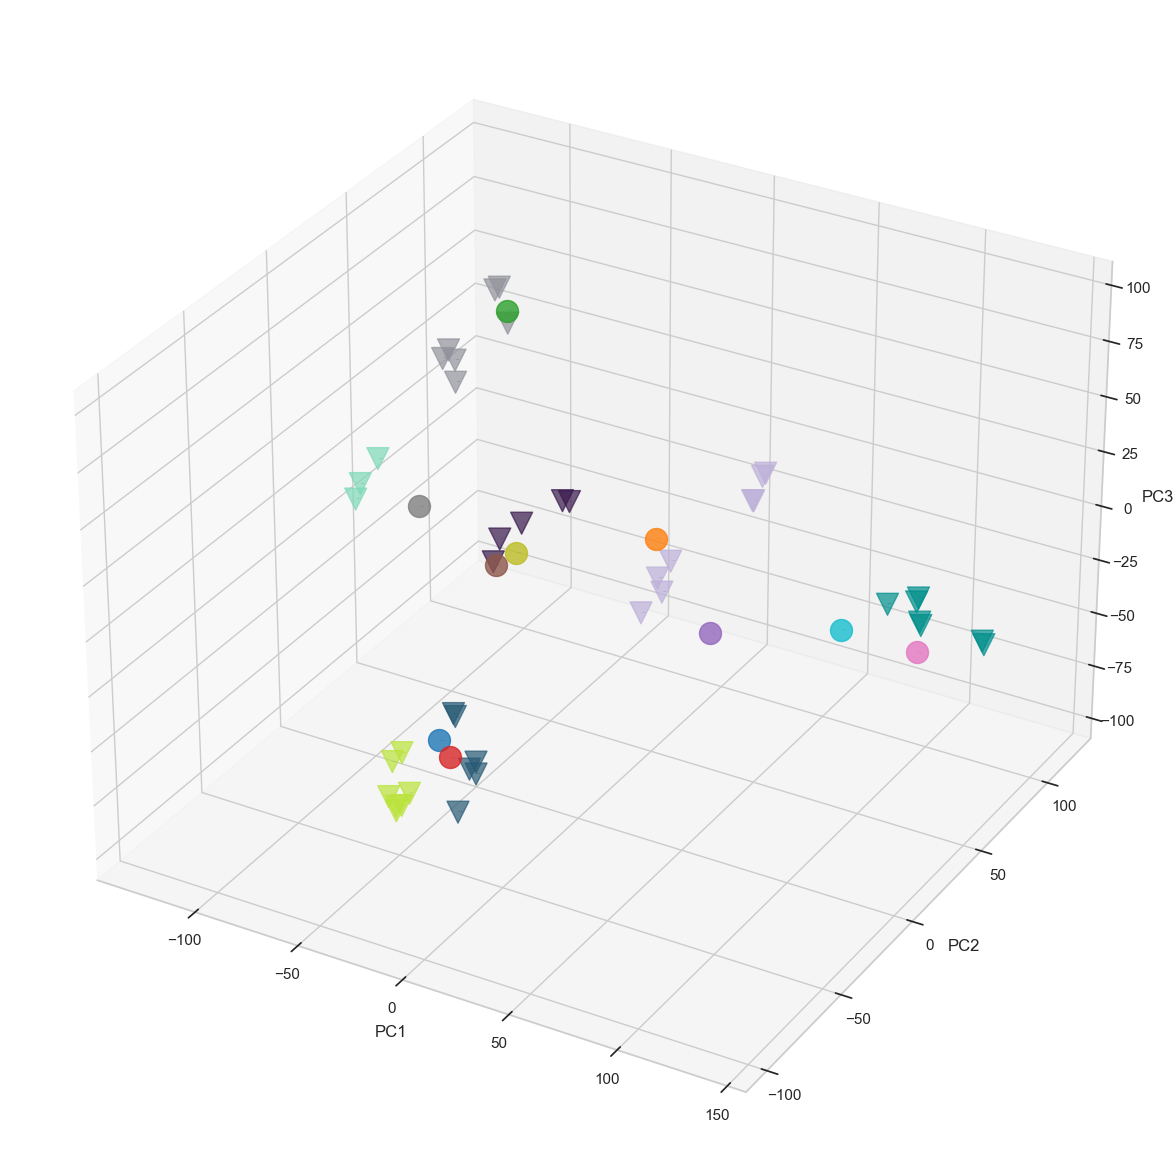

In [69]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.pdf", fig_size_inches=(15,15))


### 14 - Assign annotatiosn to clusters


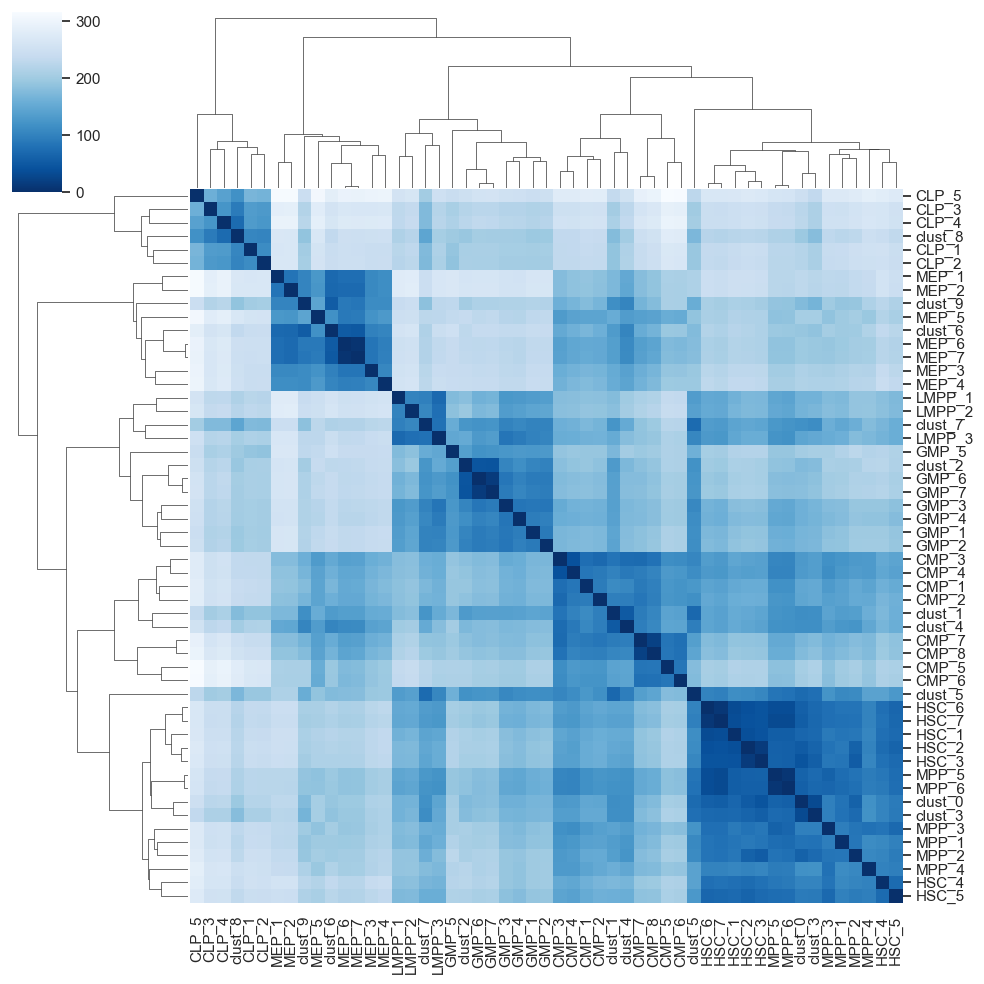

In [70]:
heatmap = scATAcat.plot_pca_dist_heatmap(result[1],result[2])

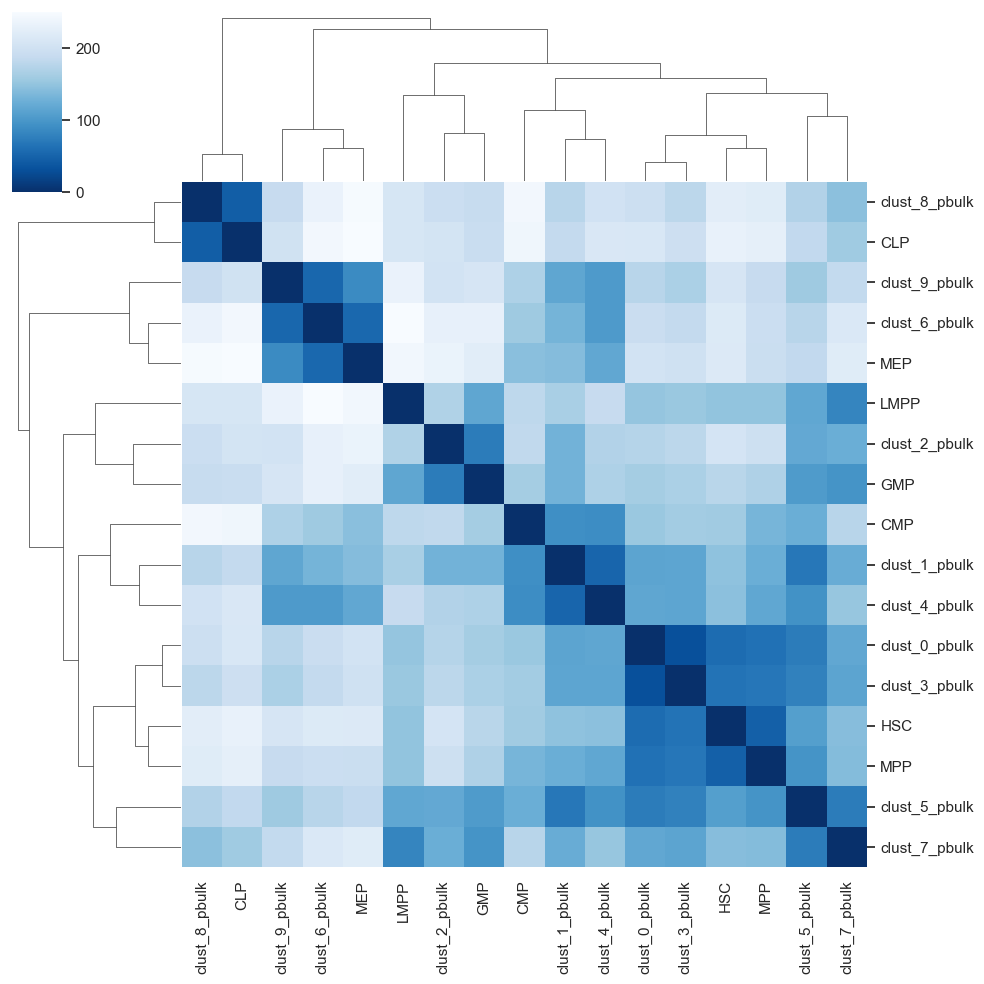

In [71]:
centroid_heatmap =  scATAcat.plot_pca_dist_cent_heatmap(result[1],result[2])


In [72]:
heatmap[0].savefig(figures_dir +"/heatmap.png") 
centroid_heatmap[0].savefig(figures_dir +"/centroid_heatmap.png") 


In [73]:
scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])

{'clust_0_pbulk': 'HSC',
 'clust_1_pbulk': 'CMP',
 'clust_2_pbulk': 'GMP',
 'clust_3_pbulk': 'HSC',
 'clust_4_pbulk': 'CMP',
 'clust_5_pbulk': 'MPP',
 'clust_6_pbulk': 'MEP',
 'clust_7_pbulk': 'LMPP',
 'clust_8_pbulk': 'CLP',
 'clust_9_pbulk': 'MEP'}

In [74]:
clusterID_prediction_dict = scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])
clusterID_prediction_dict

{'clust_0_pbulk': 'HSC',
 'clust_1_pbulk': 'CMP',
 'clust_2_pbulk': 'GMP',
 'clust_3_pbulk': 'HSC',
 'clust_4_pbulk': 'CMP',
 'clust_5_pbulk': 'MPP',
 'clust_6_pbulk': 'MEP',
 'clust_7_pbulk': 'LMPP',
 'clust_8_pbulk': 'CLP',
 'clust_9_pbulk': 'MEP'}

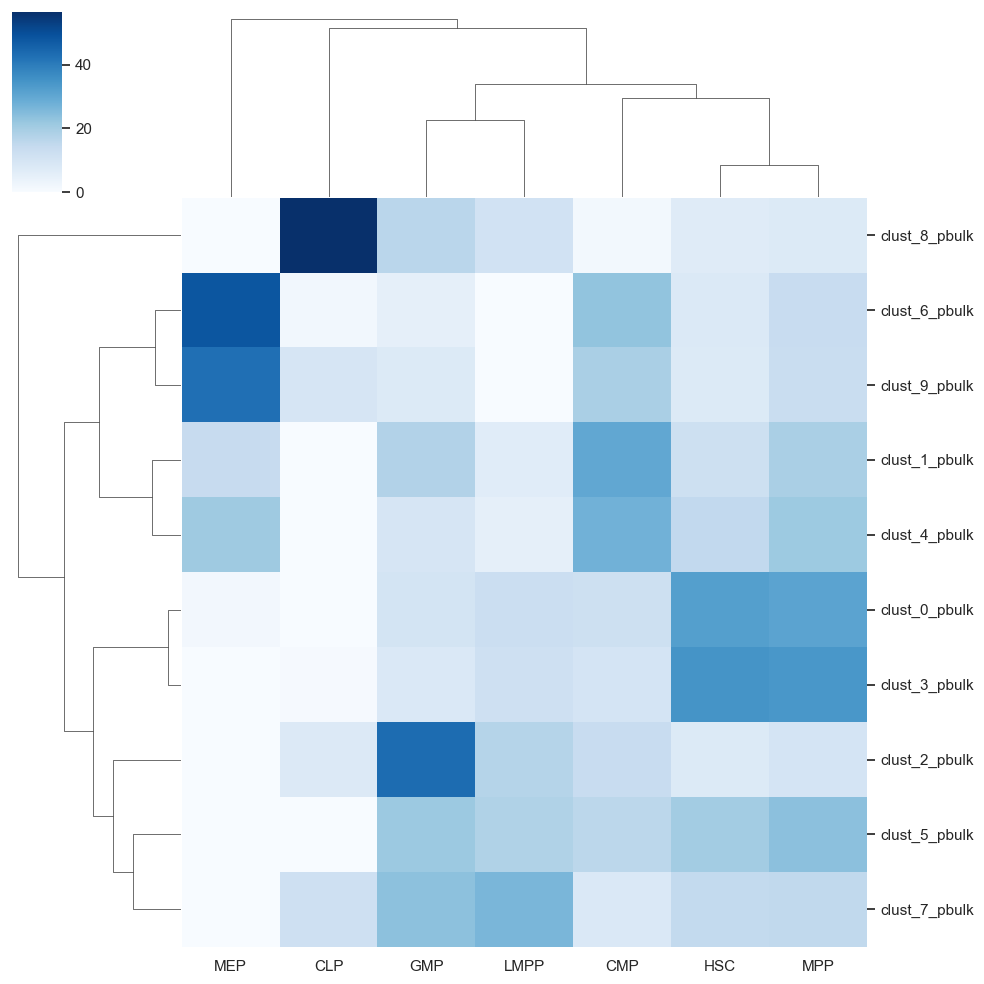

In [75]:
cluster_to_pseudobulk_heatmap_plot = sns.clustermap(scATAcat.get_pseudobulk_to_prototype_distance(centroid_heatmap[1], pbulk_to_prototype=True).T,yticklabels=True,xticklabels=True, cmap="Blues")

In [76]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.png") 


In [77]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.svg") 


In [78]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.svg") 


### 15- Post hoc analysis

In [79]:
cell_cluster_assignments_with_predictions = copy.deepcopy(cell_cluster_assignments)

#### match the clusterID with predicted cell type

In [80]:
# convert the cell id column to character 
cell_cluster_assignments_with_predictions[leiden_key] = cell_cluster_assignments_with_predictions[leiden_key].astype(str)

In [81]:
cell_cluster_assignments_with_predictions.head()

,leiden_1.0
CLP_1,8
CMP_0,4
CMP_1,4
CMP_2,1
CMP_3,6


In [82]:
# refortmat the dict suct that it mactes the clust ID col
clusterID_prediction_dict_edited = dict((''.join(filter(str.isdigit, key)), value) for (key, value) in clusterID_prediction_dict.items())
clusterID_prediction_dict_edited

{'0': 'HSC',
 '1': 'CMP',
 '2': 'GMP',
 '3': 'HSC',
 '4': 'CMP',
 '5': 'MPP',
 '6': 'MEP',
 '7': 'LMPP',
 '8': 'CLP',
 '9': 'MEP'}

In [83]:
cell_cluster_assignments_with_predictions['scATAcat_annotation'] = cell_cluster_assignments_with_predictions[leiden_key].map(clusterID_prediction_dict_edited)

In [84]:
cell_cluster_assignments_with_predictions["ground_truth_annotation"] = [i.split("_")[0] for i in cell_cluster_assignments_with_predictions.index]
cell_cluster_assignments_with_predictions

,leiden_1.0,scATAcat_annotation,ground_truth_annotation
CLP_1,8,CLP,CLP
CMP_0,4,CMP,CMP
CMP_1,4,CMP,CMP
CMP_2,1,CMP,CMP
CMP_3,6,MEP,CMP
...,...,...,...
LMPP_90,7,LMPP,LMPP
LMPP_91,7,LMPP,LMPP
LMPP_93,7,LMPP,LMPP
LMPP_94,7,LMPP,LMPP


In [85]:
cell_cluster_assignments_with_predictions.to_csv(output_dir +"/scATAcat_annotations.csv")

### 15- Post hoc analysis

In [86]:
cell_cluster_assignments_with_predictions = copy.deepcopy(cell_cluster_assignments)

#### match the clusterID with predicted cell type

In [87]:
# convert the cell id column to character 
cell_cluster_assignments_with_predictions[leiden_key] = cell_cluster_assignments_with_predictions[leiden_key].astype(str)

In [88]:
cell_cluster_assignments_with_predictions.head()

,leiden_1.0
CLP_1,8
CMP_0,4
CMP_1,4
CMP_2,1
CMP_3,6


In [89]:
# refortmat the dict suct that it mactes the clust ID col
clusterID_prediction_dict_edited = dict((''.join(filter(str.isdigit, key)), value) for (key, value) in clusterID_prediction_dict.items())
clusterID_prediction_dict_edited

{'0': 'HSC',
 '1': 'CMP',
 '2': 'GMP',
 '3': 'HSC',
 '4': 'CMP',
 '5': 'MPP',
 '6': 'MEP',
 '7': 'LMPP',
 '8': 'CLP',
 '9': 'MEP'}

In [90]:
cell_cluster_assignments_with_predictions['scATAcat_annotation'] = cell_cluster_assignments_with_predictions[leiden_key].map(clusterID_prediction_dict_edited)

In [91]:
cell_cluster_assignments_with_predictions["ground_truth_annotation"] = [i.split("_")[0] for i in cell_cluster_assignments_with_predictions.index]
cell_cluster_assignments_with_predictions

,leiden_1.0,scATAcat_annotation,ground_truth_annotation
CLP_1,8,CLP,CLP
CMP_0,4,CMP,CMP
CMP_1,4,CMP,CMP
CMP_2,1,CMP,CMP
CMP_3,6,MEP,CMP
...,...,...,...
LMPP_90,7,LMPP,LMPP
LMPP_91,7,LMPP,LMPP
LMPP_93,7,LMPP,LMPP
LMPP_94,7,LMPP,LMPP


In [92]:
cell_cluster_assignments_with_predictions[cell_cluster_assignments_with_predictions.scATAcat_annotation == cell_cluster_assignments_with_predictions.ground_truth_annotation]

,leiden_1.0,scATAcat_annotation,ground_truth_annotation
CLP_1,8,CLP,CLP
CMP_0,4,CMP,CMP
CMP_1,4,CMP,CMP
CMP_2,1,CMP,CMP
CMP_5,4,CMP,CMP
...,...,...,...
LMPP_90,7,LMPP,LMPP
LMPP_91,7,LMPP,LMPP
LMPP_93,7,LMPP,LMPP
LMPP_94,7,LMPP,LMPP


## export AnnData object

In [111]:

with open(output_dir +'/sc_commonDiffFeatures_adata.pkl', 'wb') as f:
    pickle.dump(sc_commonDiffFeatures_adata, f)

In [112]:
cell_cluster_assignments.to_csv(output_dir +"cell_cluster_assignments.csv")